In [0]:
# https://github.com/42io/dataset/tree/master/google_speech_commands#numpy-example
DATASET_FILE = '1gmnWx2we0I-RNiWSvIRN7RzUrJrSp_uQ' # 0-9up.npz

In [0]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

In [0]:
import subprocess
assert(b'cb126d837b86b1f6baf5c8268804877a' == subprocess.run(['md5sum', DATASET_FILE], stdout=subprocess.PIPE).stdout.split()[0])

In [0]:
%tensorflow_version 2.x
import numpy as np
from tensorflow import keras as keras
!nvidia-smi

Wed Apr  8 19:07:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# see https://github.com/42io/dataset/tree/master/google_speech_commands#numpy-example
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

In [0]:
x_train_4d = dset['x_train'].reshape(len(dset['x_train']), 49, 13, 1)[:,1:-1]
x_test_4d = dset['x_test'].reshape(len(dset['x_test']), 49, 13, 1)[:,1:-1]
x_valid_4d = dset['x_valid'].reshape(len(dset['x_valid']), 49, 13, 1)[:,1:-1]

In [0]:
x_in = keras.Input(shape=(47, 13, 1))

x = keras.layers.Conv2D(32, kernel_size=(1, 13), use_bias=False)(x_in)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.DepthwiseConv2D(kernel_size=(13, 1), use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Conv2D(32, kernel_size=(1, 1), use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.MaxPooling2D(pool_size=(35, 1))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(32, use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Dense(12, activation='softmax')(x)

model = keras.Model(inputs=x_in, outputs=x)

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

history = model.fit(x_train_4d,
                    keras.utils.to_categorical(dset['y_train']),
                    validation_data=(x_valid_4d, keras.utils.to_categorical(dset['y_valid'])),
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=100500)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47, 13, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 1, 32)         416       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 1, 32)         128       
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 1, 32)         0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 35, 1, 32)         416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 1, 32)         128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 35, 1, 32)         0     

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


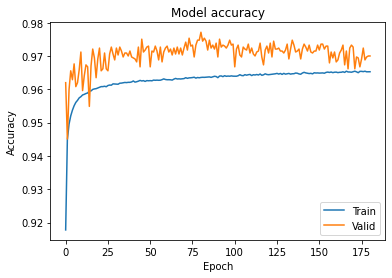

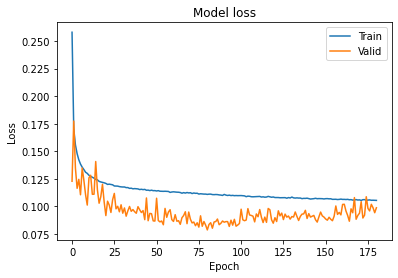

In [0]:
print(history.history.keys())

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [0]:
results = model.evaluate(x_train_4d, keras.utils.to_categorical(dset['y_train']), verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(x_test_4d, keras.utils.to_categorical(dset['y_test']), verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(x_valid_4d, keras.utils.to_categorical(dset['y_valid']), verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.0845278650522232, 0.9724230766296387]
test loss, test acc: [0.12034226953983307, 0.9618340730667114]
valid loss, valid acc: [0.07859799265861511, 0.9771377444267273]


In [0]:
assert(len(x_test_4d) + len(x_valid_4d) == 7141)
pred = model.predict(x_test_4d).argmax(axis=-1)
print(np.sum(pred != dset['y_test']), len(pred))
pred = model.predict(x_valid_4d).argmax(axis=-1)
print(np.sum(pred != dset['y_valid']), len(pred))

144 3773
77 3368


In [0]:
import tensorflow as tf
print(tf.__version__)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = False
tflite_model = converter.convert()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!mkdir -p '/content/gdrive/My Drive/kws/models'
with open("/content/gdrive/My Drive/kws/models/dcnn.tflite", "wb") as f:
  f.write(tflite_model)
!md5sum "/content/gdrive/My Drive/kws/models/dcnn.tflite"

19fcb205406bb0a27dfeee76af900d57  /content/gdrive/My Drive/kws/models/dcnn.tflite
